### Calculate indicies from daily BOM data
***
Summarise variables by month (e.g. max of month), and then average over months for the years in a given period.

* Tmin min max
* Tmax min max
* Rain max
* Rain days
* Frost days

In [18]:
import numpy as np
from maclab.maclab import slurm as sl
from maclab.maclab import spatial as sp

In [82]:
# run all
opts = ['TXx', 'TNx', 'TXn', "TNn", "FD", "R1", "Rx1day"]
filepaths = ['/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/tmax_nc_files.txt',
            '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/tmin_nc_files.txt',
            '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/tmax_nc_files.txt',
            '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/tmin_nc_files.txt',
            '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/tmin_nc_files.txt',
            '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/rain_nc_files.txt',
            '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960/rain_nc_files.txt']
sh = []
for i in range(7):
    sh.append(sl.config('/home/war42q/.local/lib/python3.6/site-packages/climate_indicies/calc.py', 
              mem=56, time='00:29:00', ntasks=1, nodes=1, env='python/3.6.1', 
              jobname=opts[i], stdout='{0}.txt'.format(opts[i]), 
              cli_args = [{'-f': filepaths[i],
                          '-i': opts[i], 
                          '-d': '/OSM/CBR/LW_BACKCAST/work/DEV/awap_indicies/base-period-1960',
                          '-fn': '1960C'}, ['-v']]))

In [ ]:
jobs = [sl.sbatch(i) for i in sh]

***
** Mask and convert to flt **  
  
I think there is an AWAP mask (or BOM mask?) somewhere. But I cannot find it. I need to mask out the ocean, however, so I'll just use one of Herry's flt grids which will force consistency. 

In [462]:
src = '/OSM/CDC/GISDATA/work/_SOURCE/AUS/AWAP/RECA/monthly/years1901_2017/Centered1960/'
templates = ut.listfiles(src, '.flt$')
template = templates[0]
mask = sp.Raster(template)
mask_meta = mask.meta
mask_data = mask.read().array.squeeze()
print('Using the following file as a mask:\n{0}'.format(template))

Using the following file as a mask:
/OSM/CDC/GISDATA/work/_SOURCE/AUS/AWAP/RECA/monthly/years1901_2017/Centered1960/mean_FWWater_range_period-1975_1946.flt


/apps/python/3.6.1/lib/python3.6/site-packages/matplotlib-2.0.2-py3.6-linux-x86_64.egg/matplotlib/colors.py:861: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


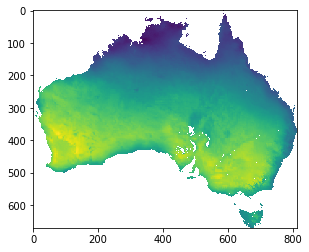

In [464]:
from matplotlib import pyplot as plt
%matplotlib inline
masked = np.ma.array(mask_data, mask = (mask_data <= -9999))
plt.imshow(masked)

In [ ]:
# run
from homebaked import spatial # to write flt
for i in indicies:
    cropped = sp.crop_raster(i, template)
    cropped[mask_data <= -9999] = -9999
    dst = os.path.dirname(os.path.dirname(i)) + '/flt/'
    dst = dst + os.path.basename(i[:-4]) + '.flt'
    spatial.write_flt(cropped.astype('float32'), mask_meta, dst)
    #print(dst)